In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import linemerge
from shapely import geometry
import momepy as mm # outputs a 'TqdmWarning'

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def selecting_rabs_from_poly(gdf, circom_threshold = 0.7):
    """
    From a GeoDataFrame of polygons, returns a GDF of polygons that are 
    above the CircularCompaactness threshold as well as those adjacent ones samller in area
    that make up for a combined roundabout to be corrected
    
    Return
    ________
    GeoDataFrames : round abouts and adjacent polygons
    """
    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series
    
    #selecting round about polygons based on compactness
    rab = gdf[gdf.circom > circom_threshold]
    
    #selecting the adjacent areas that are of smaller than itself
    rab = gpd.sjoin(gdf, rab, predicate = 'intersects')
    rab = rab[rab.area_right >= rab.area_left]
    rab = rab[['geometry', 'index_right']]
    
    return rab

In [3]:
def rabs_center_points(gdf, center_type = 'mean'):
    """
    From a selection of round abouts, returns an aggregated GeoDataFrame 
    per round about with extra column with center_type. 
    
    center_type, str
        - mean: (default) mean point of node geometries that make up polygons
        - centroid : of the combined polygons
        - minimum_bounding_circle : TBD
    
    Return
    ________
    GeoDataFrame
    """
    #dissolving into a single geometry per round about
    rab_plus = gdf.dissolve(by = 'index_right')
    
    if center_type == 'mean':
        # mean geometry
        ls_xy = [g.exterior.coords.xy for g in rab_plus.geometry] #extracting the points
        mean_pts = [geometry.Point(np.mean(xy[0]),np.mean(xy[1])) for xy in ls_xy]
        rab_plus['center_pt'] = gpd.GeoSeries( data = mean_pts, 
                                              index = rab_plus.index, 
                                              crs = edges.crs)
    
    elif center_type == 'centroid' :
        #geometry centroid
        rab_plus['center_pt'] = rab_plus.geometry.centroid
    
    # centerpoint of minimum_bounding_circle
    # minimun_bounding_circle() not available in Shapely 1.8.2 but only in 'latest'
    # --> https://shapely.readthedocs.io/en/latest/constructive.html
    # current environment has 1.8.2
    
    return rab_plus

In [4]:
def coins_filtering_many_incoming(incoming_many, angle_threshold=0):
    # From multiple incoming lines 
    # figuring out which one needs to be extended and retain attributes
    coins_filter_result = []
    # For each new connection, evaluate COINS and selecet the group from which the new line belongs
    for g, x in incoming_many.groupby('line_wkt'):
        gs = gpd.GeoSeries( pd.concat([x.geometry, x.line]), crs= incoming_many.crs )
        gdf = gpd.GeoDataFrame(geometry = gs)
        gdf.drop_duplicates(inplace=True)

        coins = mm.COINS(gdf, angle_threshold=angle_threshold)
        stroke_gdf = coins.stroke_gdf()

        orig_geom_join = stroke_gdf.sjoin(gpd.GeoDataFrame(geometry = x.line), predicate= 'covers' )
        orig_geom = gpd.GeoSeries([orig_geom_join.geometry.iloc[0]], crs= incoming_many.crs)
        gs2 = gpd.GeoDataFrame(geometry = orig_geom)

        gs1 = gpd.GeoSeries(x.geometry, crs= incoming_many.crs )
        gs1 = gpd.GeoDataFrame(geometry = gs1)

        #select the the line that's covered by the joined line returned by COINS
        result_idx = gs1.sjoin(gs2 , predicate = 'covered_by').index
        coins_filter_result.extend(result_idx)
    
    incoming_many_reduced = incoming_many.loc[coins_filter_result]
    return incoming_many_reduced

In [5]:
def selecting_incoming_lines (rab_plus, edges, angle_threshold=0):
    # selecting only the lines that are touching but not covered_by
    # Feels a bit combersome ... Ideally there would be a DISJOINT predicate
    incoming = edges.sjoin(rab_plus , predicate = 'touches')
    incoming.rename(columns ={'index_right':'index_rab_plus'}, inplace = True )
    idx_drop =  incoming.sjoin(rab_plus, predicate = 'covered_by').index
    incoming.drop(idx_drop, axis=0, inplace =True)

    #figuring out which ends of incoming edges needs to be connected to the center_pt
    incoming['first_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[0]))
    incoming['dist_fisrt_pt'] = incoming.center_pt.distance(incoming.first_pt)
    incoming['last_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[-1]))
    incoming['dist_last_pt'] = incoming.center_pt.distance(incoming.last_pt)
    lines = []
    for i, row in incoming.iterrows() :
        if row.dist_fisrt_pt < row.dist_last_pt :
            lines.append(geometry.LineString([row.first_pt, row.center_pt]))
        else :
            lines.append( geometry.LineString([row.last_pt, row.center_pt]))
    incoming['line'] = gpd.GeoSeries(lines, index=incoming.index ,crs= edges.crs)

    #checking in there are more than one incoming lines arriving to the same point
    #which would create several new lines
    incoming['line_wkt'] = incoming.line.apply(lambda x : x.wkt)
    count_s = incoming.groupby(['line_wkt'])['line_wkt'].count()
    
    #separating the incoming roads that come on their own to those that come in groups
    filter_count_one  = pd.DataFrame(count_s[count_s == 1])
    filter_count_many  = pd.DataFrame(count_s[count_s > 1])
    incoming_ones = pd.merge(incoming, filter_count_one, left_on='line_wkt', right_index=True, how= 'inner')
    incoming_many = pd.merge(incoming, filter_count_many, left_on='line_wkt', right_index=True, how= 'inner')

    incoming_many_reduced = coins_filtering_many_incoming(incoming_many, angle_threshold=angle_threshold)
    incoming_all = gpd.GeoDataFrame(pd.concat([ incoming_ones, incoming_many_reduced]), crs = edges.crs)
    
    return incoming_all

In [6]:
def ext_lines_to_center(edges, incoming_all, rab_plus):
    # updating the original geometry 
    ## this is causing a warning too for Shapely 2.0 --> Convert the '.coords' to a numpy array
    incoming_all['geometry'] = incoming_all.apply(lambda row: linemerge([row.geometry, row.line]), axis =1)

    # deleting the original round about edges
    idx_out = edges.sjoin(rab_plus, predicate= 'covered_by', how='inner').index
    new_edges = edges.drop(idx_out, axis=0)
                        
    #replacing the modified edges in the output
    #ideally uising MAPPING but I didn't manage to make it work with multiindex!!
    
    #mantianing the same gdf shape that the original
    incoming_all = incoming_all[edges.columns]
    new_edges = pd.concat([new_edges, incoming_all])
    
    return new_edges

In [22]:
def roundabout_simpl(edges, polys, circom_threshold = 0.7, center_type = 'mean', angle_threshold=0):
    
    rab = selecting_rabs_from_poly(polys, circom_threshold = circom_threshold)
    rab_plus = rabs_center_points(rab, center_type = center_type)
    incoming_all = selecting_incoming_lines(rab_plus, edges, angle_threshold=angle_threshold)
    output = ext_lines_to_center(edges, incoming_all, rab_plus)
    
    return output

# Testing performance of different componenets of the overall function

In [8]:
import osmnx as ox
from shapely.ops import polygonize

<AxesSubplot:>

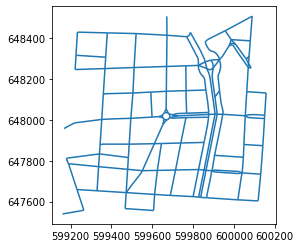

In [9]:
#loading test data
point = 40.432996, -3.691383
dist = 500
G = ox.graph_from_point(point, dist=dist, network_type='drive', simplify = True)
G_projected = ox.project_graph(G)
edges = ox.graph_to_gdfs(ox.get_undirected(G_projected), #prevents some (semi)duplicate geoms
                         nodes=False, edges=True,
                         node_geometry=False, fill_edge_geometry=True)
edges.to_crs(2062, inplace= True)
edges.plot()

<AxesSubplot:>

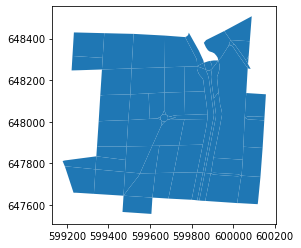

In [10]:
polys = polygonize(edges.geometry)
polys = gpd.GeoDataFrame(geometry = [g for g in polys], crs=edges.crs)
polys.plot()

## 1st Step testing 
Selecting roundabouts from polys

<AxesSubplot:>

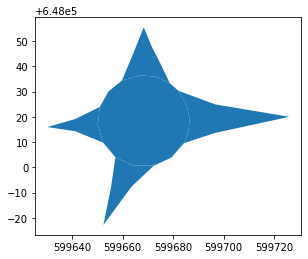

In [11]:
#restricting to a single round about for tests (i.e. circom_threshold = 0.8)
rab = selecting_rabs_from_poly(polys, circom_threshold = 0.8)
rab.plot()

In [12]:
%%timeit
selecting_rabs_from_poly(polys, circom_threshold = 0.8)

17.5 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 2nd Step testing
Calculating different centerpoints against each other

<AxesSubplot:>

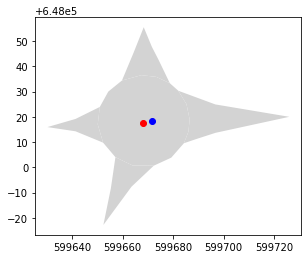

In [13]:
rab_mean = rabs_center_points(rab, center_type = 'mean')
rab_centroid = rabs_center_points(rab, center_type = 'centroid')

ax = rab.plot(color = 'lightgrey')
rab_mean.center_pt.plot(ax=ax , color = 'red')
rab_centroid.center_pt.plot(ax=ax , color = 'blue')

In [14]:
%%timeit
rabs_center_points(rab, center_type = 'mean')

4 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
rabs_center_points(rab, center_type = 'centroid')

4.31 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 3rd Step testing
Selecting incoming lines that need to be joined in the center

<AxesSubplot:>

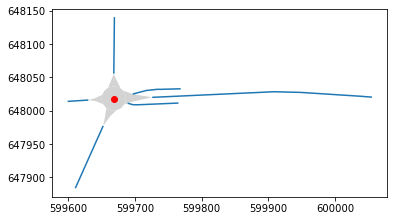

In [16]:
incoming_all = selecting_incoming_lines(rab_mean, edges)

ax = rab.plot(color = 'lightgrey')
rab_mean.center_pt.plot(ax=ax , color = 'red')
incoming_all.plot(ax=ax)

<AxesSubplot:>

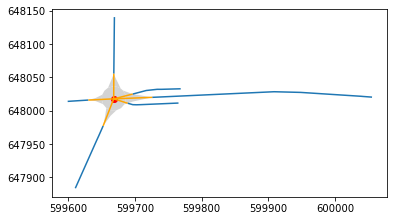

In [17]:
#this step also produces the pared incoming lines. They look like so
ax = rab.plot(color = 'lightgrey')

incoming_all.plot(ax=ax)
incoming_all.line.plot(ax=ax, color = 'orange')

rab_mean.center_pt.plot(ax=ax , color = 'red')

In [18]:
%%timeit
selecting_incoming_lines(rab_mean, edges)

37.4 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 4th Step testing
Merging/extending the lines and reshaping the ouput to match the original edge GDF

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

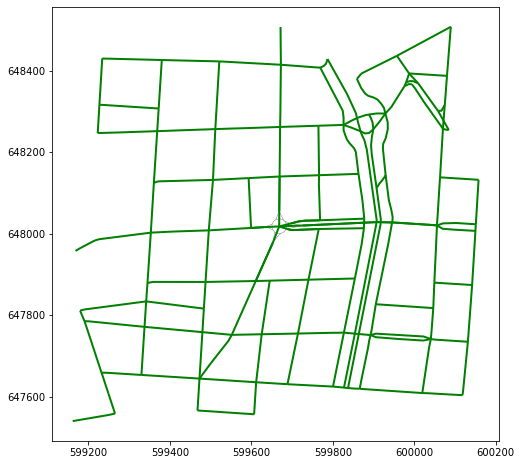

In [19]:
output = ext_lines_to_center(edges, incoming_all, rab_mean)

ax = edges.plot(figsize = (8,8),color='grey', linewidth =0.5)
output.plot(ax=ax , color = 'green',linewidth =2 )

In [20]:
#I couldn't run this beacuase of excesive warnings !!
#%%timeit
#ext_lines_to_center(edges, incoming_all, rab_mean)

## 5th (final) testing
Where all the previous four steps are put together into a fingle function

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

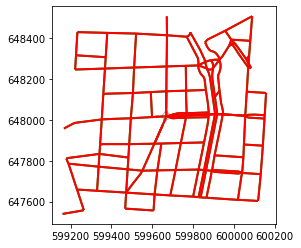

In [23]:
simpl_mean = roundabout_simpl(edges, polys, circom_threshold = 0.8, center_type = 'mean')
simpl_centroid = roundabout_simpl(edges, polys, circom_threshold = 0.8, center_type = 'centroid')

ax = edges.plot(color='grey', linewidth =0.5)
simpl_mean.plot(ax=ax , color = 'green',linewidth = 2 )
simpl_centroid.plot(ax=ax , color = 'red',linewidth = 2 )

In [ ]:
#same problemas above: too amny warnings and not final TIMEIT output! 
#%%timeit
#round_about_simpl(edges, polys, circom_threshold = 0.8, center_type = 'mean')

# Final representation of all possiblilities

In [24]:
import folium

In [25]:
new_edges = roundabout_simpl(edges, polys)
new_edges_centroid = roundabout_simpl(edges, polys, center_type='centroid')
new_edges_single_rab_centroid = roundabout_simpl(edges, polys, circom_threshold = 0.7)
new_edge_single_rab_mean = roundabout_simpl(edges, polys, circom_threshold = 0.7, center_type = 'centroid' )


m = edges.explore(name='edges', color ='black')
new_edges.explore( m=m, color = 'orange', name= 'mean + all rabs' )
new_edges_centroid.explore( m=m, color = 'red', name= 'centroid + all rabs' ) 
new_edges_single_rab_centroid.explore( m=m, color = 'yellow', name= 'centroid + single rab' )
new_edge_single_rab_mean.explore(m=m, color = 'blue', name= 'mean + single rab' ) 

folium.LayerControl().add_to(m)  # layer control
m

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/co

## Case Cahors

<AxesSubplot:>

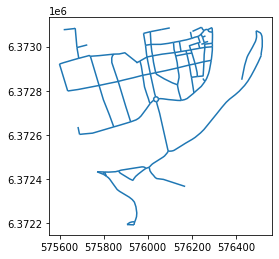

In [26]:
#loading test data
point = 44.44153134074367, 1.4425789976776586
dist = 500
G = ox.graph_from_point(point, dist=dist, network_type='drive', simplify = True)
G_projected = ox.project_graph(G)
edges = ox.graph_to_gdfs(ox.get_undirected(G_projected), #prevents some (semi)duplicate geoms
                         nodes=False, edges=True,
                         node_geometry=False, fill_edge_geometry=True)
edges.to_crs(2154, inplace= True) #FRANCE
edges.plot()

<AxesSubplot:>

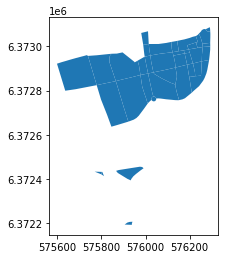

In [27]:
polys = polygonize(edges.geometry)
polys = gpd.GeoDataFrame(geometry = [g for g in polys], crs=edges.crs)
polys.plot()

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

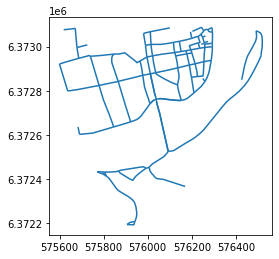

In [28]:
new_cahors = roundabout_simpl(edges, polys)
new_cahors.plot()

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

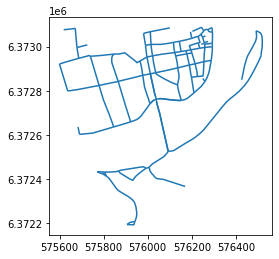

In [87]:
# updating the original geometry 
## this is causing a warning too for Shapely 2.0 --> Convert the '.coords' to a numpy array
incoming_all['geometry'] = incoming_all.apply(lambda row: linemerge([row.geometry, row.line]), axis =1)

# deleting the original round about edges
idx_out = edges.sjoin(rab_plus, predicate= 'covered_by', how='inner').index
new_edges = edges.drop(idx_out, axis=0)

#replacing the modified edges in the output
#ideally uising MAPPING but I didn't manage to make it work with multiindex!!

#mantianing the same gdf shape that the original
incoming_all = incoming_all[edges.columns]
new_edges = pd.concat([new_edges, incoming_all])
new_edges.plot()